In [14]:
import gymnasium as gym
import flappy_bird_gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
import matplotlib.pyplot as plt
import numpy as np
import os
from torch import multiprocessing
import torch
#import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.policies import ActorCriticCnnPolicy
import torch
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
class CustomFlappyBirdEnv(FlappyBirdEnv):
    def __init__(self, render_mode=None, use_lidar=False, **kwargs):
        super(CustomFlappyBirdEnv, self).__init__(render_mode=render_mode, use_lidar=use_lidar, **kwargs)
        self.pipe_gap = 150  # Beispiel: Änderung des Abstands zwischen den Rohren
        self.gravity = 0.5  # Beispiel: Änderung der Schwerkraft

    def _get_reward(self):
        reward = 0.4  # +0.1 - every frame it stays alive
        if self.player['y'] + self.player['h'] >= self.screen_height:
            reward = -20.0  # -1.0 - dying
        elif self.player['y'] <= 0:
            reward = -10  # -0.5 - touch the top of the screen
        elif self.pipe_passed:
            reward = 100.0  # +1.0 - successfully passing a pipe
        return reward

# Registrieren Sie die benutzerdefinierte Umgebung
gym.envs.registration.register(
    id='CustomFlappyBird-v0',
    entry_point='__main__:CustomFlappyBirdEnv',
    max_episode_steps=100000,
)

In [4]:
class TubeCountCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TubeCountCallback, self).__init__(verbose)
        self.tube_counts = []

    def _on_step(self) -> bool:
        # Hier setzen wir die Logik für das Zählen der Röhren
        # Angenommen, die Umgebungsinfo enthält die Anzahl der überwundenen Röhren
        for info in self.locals['infos']:
            if 'tubes' in info:
                self.tube_counts.append(info['tubes'])
        return True
    
# Initialisieren des Callbacks
tube_count_callback = TubeCountCallback()

In [6]:
# Environment erstellen
env = make_vec_env("CustomFlappyBird-v0", n_envs=4, env_kwargs={'render_mode': 'rgb_array', 'use_lidar': False})

In [51]:
class CustomMLP(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super(CustomMLP, self).__init__(observation_space, features_dim)
        n_input_dim = observation_space.shape[0]
        
        self.mlp = nn.Sequential(
            nn.Linear(n_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        return self.mlp(observations)



In [7]:
# Erstellen der benutzerdefinierten Umgebung mit make_vec_env
env = make_vec_env("CustomFlappyBird-v0", n_envs=4, env_kwargs={'render_mode': 'rgb_array', 'use_lidar': False})

# Definieren der benutzerdefinierten Netzarchitektur für das PPO-Modell
policy_kwargs = dict(
    features_extractor_class=CustomMLP,
    features_extractor_kwargs=dict(features_dim=256),
)

# Initialisieren des PPO-Modells
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

# Trainieren des Modells
model.learn(total_timesteps=100000,callback=tube_count_callback)

# Speichern des Modells
model.save("ppo_flappybird_custom_cnn")

# Laden des Modells (falls benötigt)
model = PPO.load("ppo_flappybird_custom_cnn")

# Evaluieren des Modells
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -7.55    |
| time/              |          |
|    fps             | 3275     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -8.09       |
| time/                   |             |
|    fps                  | 990         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.010761886 |
|    clip_fraction        | 0.013       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | -0.00244    |
|    learning

# Laden der Modelle

In [7]:
# Laden des Modells (falls benötigt)
model = PPO.load("kathi_models/ppo_flappybird_custom_cnn")

# Evaluieren der Modelle

In [11]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 3.899999999999998 +/- 1.7763568394002505e-15


In [56]:
# Listen zum Speichern der Belohnungen und der Schritte
reward_list = []
timesteps_list = []

# Callback-Funktion zur Überwachung des Trainingsfortschritts
def callback(_locals, _globals):
    global reward_list, timesteps_list

    # Überwachen der Belohnungen und der Schritte
    if len(_locals['self'].ep_info_buffer) > 0:
        reward_list.append(_locals['self'].ep_info_buffer[0]['r'])
        timesteps_list.append(_locals['self'].num_timesteps)
    
    # Plot und speichern der Grafik alle 100000 Schritte
    if _locals['self'].num_timesteps % 100000 == 0:
        plot_and_save_progress()

    return True

def plot_and_save_progress():
    plt.figure(figsize=(12, 6))
    plt.plot(timesteps_list, reward_list)
    plt.xlabel('Timesteps')
    plt.ylabel('Reward')
    plt.title('Training Progress')

    # Erstellen Sie das Verzeichnis, falls es nicht existiert
    os.makedirs('RL_Flappy_Bird/kathi_img', exist_ok=True)

    # Save the plot as a PNG file
    plt.savefig('RL_Flappy_Bird/kathi_img/training_progress.png')

    # Save the plot as a JPG file (if needed)
    plt.savefig('RL_Flappy_Bird/kathi_img/training_progress.jpg')

    plt.close()

In [25]:
plot_and_save_progress()

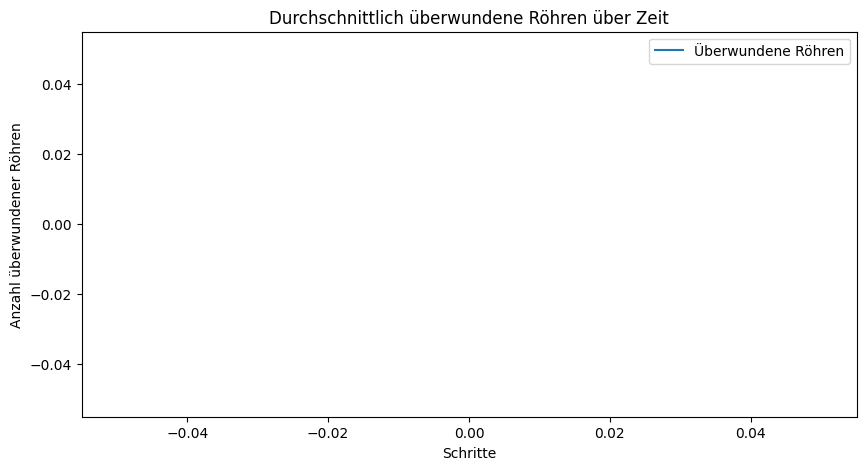

In [12]:
import matplotlib.pyplot as plt

# Berechnen des durchschnittlichen Röhrenüberwindens über Zeit
tube_counts = tube_count_callback.tube_counts

# Erstellen des Plots
plt.figure(figsize=(10, 5))
plt.plot(tube_counts, label='Überwundene Röhren')
plt.xlabel('Schritte')
plt.ylabel('Anzahl überwundener Röhren')
plt.title('Durchschnittlich überwundene Röhren über Zeit')
plt.legend()
plt.show()


In [11]:
# # Modell trainieren mit Callback
# model.learn(total_timesteps=1000000, callback=callback)

In [12]:
# # Modell speichern
# model.save("models/ppo_flappybird_custom_v2")

# # Evaluate the trained agent
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
# print(f"Mean reward: {mean_reward} +/- {std_reward}")

# # Plotting the final training progress
# plot_and_save_progress()

# # Teste den trainierten Agenten
# obs = env.reset()
# while True:
#     action, _states = model.predict(obs)
#     obs, rewards, dones, info = env.step(action)
#     env.render()
#     if dones:
#         break

# env.close()
